# Newyork city Taxi Demand Prediction Data Processing and modeling

   Please review and visit  [NYC Taxi Demand EDA](https://www.kaggle.com/chiragtagadiya/nyc-taxi-demand-prediction-eda/edit) for Data Analysis.
   
   This Notebook cotains data preprocessing and Data Modeling
   

## Features in the dataset:
<table border="1">
        <tr>
            <th>Field Name</th>
            <th>Description</th>
        </tr>
        <tr>
            <td>VendorID</td>
            <td>
            A code indicating the TPEP provider that provided the record.
            <ol>
                <li>Creative Mobile Technologies</li>
                <li>VeriFone Inc.</li>
            </ol>
            </td>
        </tr>
        <tr>
            <td>tpep_pickup_datetime</td>
            <td>The date and time when the meter was engaged.</td>
        </tr>
        <tr>
            <td>tpep_dropoff_datetime</td>
            <td>The date and time when the meter was disengaged.</td>
        </tr>
        <tr>
            <td>Passenger_count</td>
            <td>The number of passengers in the vehicle. This is a driver-entered value.</td>
        </tr>
        <tr>
            <td>Trip_distance</td>
            <td>The elapsed trip distance in miles reported by the taximeter.</td>
        </tr>
        <tr>
            <td>Pickup_longitude</td>
            <td>Longitude where the meter was engaged.</td>
        </tr>
        <tr>
            <td>Pickup_latitude</td>
            <td>Latitude where the meter was engaged.</td>
        </tr>
        <tr>
            <td>RateCodeID</td>
            <td>The final rate code in effect at the end of the trip.
            <ol>
                <li> Standard rate </li>
                <li> JFK </li>
                <li> Newark </li>
                <li> Nassau or Westchester</li>
                <li> Negotiated fare </li>
                <li> Group ride</li>
            </ol>
            </td>
        </tr>
        <tr>
            <td>Store_and_fwd_flag</td>
            <td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br> aka “store and forward,” because the vehicle did not have a connection to the server.<br><br>
                Y= store and forward trip<br>
                N= not a store and forward trip<br>
            </td>
        </tr>
        <tr>
            <td>Dropoff_longitude</td>
            <td>Longitude where the meter was disengaged.</td>
        </tr>
        <tr>
            <td>Dropoff_ latitude</td>
            <td>Latitude where the meter was disengaged.</td>
        </tr>
        <tr>
            <td>Payment_type</td>
            <td>A numeric code signifying how the passenger paid for the trip.
            <ol>
                <li> Credit card </li>
                <li> Cash </li>
                <li> No charge </li>
                <li> Dispute</li>
                <li> Unknown </li>
                <li> Voided trip</li>
            </ol>
            </td>
        </tr>
        <tr>
            <td>Fare_amount</td>
            <td>The time-and-distance fare calculated by the meter.</td>
        </tr>
        <tr>
            <td>Extra</td>
            <td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
        </tr>
        <tr>
            <td>MTA_tax</td>
            <td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
        </tr>
        <tr>
            <td>Improvement_surcharge</td>
            <td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
        </tr>
        <tr>
            <td>Tip_amount</td>
            <td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
        </tr>
        <tr>
            <td>Tolls_amount</td>
            <td>Total amount of all tolls paid in trip.</td>
        </tr>
        <tr>
            <td>Total_amount</td>
            <td>The total amount charged to passengers. Does not include cash tips.</td>
        </tr>
</table>

In [1]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

#!pip3 install folium
import folium #open street map

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

import numpy as np#Do aritmetic operations on arrays

# matplotlib: used to plot graphs
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
#!pip install gpxpy
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os


# to install xgboost: 
# !conda install py-xgboost --yes
#!pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")



## Data Processing Pipiline


In [2]:
def convert_to_unix_timestamp(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

In [3]:


"""
Returned Columns:
    # 1. passenger_count
    # 2. trip_distance
    # 3. pickup_longitude
    # 4. dropoff_latitude
    # 5. dropoff_longitude
    # 6. pickup_latitude
    # 7. total_amount : total paid fair amount
    # 8. trip_times :  duration of each trip
    # 9. pickup_times : pickup time converted into unix time 
    # 10.drop times: drop time converted to unix time
    # 11.Speed : velocity of each trip
"""

def create_dataframe_with_trip_times(df):
    
    duration_df = df[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    # get pickup values in unix time
    pickup_times = [convert_to_unix_timestamp(value) for value in duration_df['tpep_pickup_datetime'].values]
    # get dropoff values in unix time
    drop_times = [convert_to_unix_timestamp(value) for value in duration_df['tpep_dropoff_datetime'].values]
    # drop times and pickup times devide by 60 will give minutes
    trip_times = (np.array(drop_times) - np.array(pickup_times))/ float(60) 
    result_df = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    result_df['trip_times'] = trip_times
    result_df['pickup_times'] = pickup_times
    result_df['drop_times'] = drop_times
    # velocity = distance/ duration
    result_df['Speed'] = 60*(result_df['trip_distance']/result_df['trip_times'])
    
    return result_df


In [4]:
def remove_outliers(df):
    print("Number of records in dataframe : {}".format(df.shape[0]))
    # remove Latitude and longitude errors and outliers
    a = df.shape[0]
    temp_frame = df[((df.dropoff_longitude >= -74.15) & (df.dropoff_longitude <= -73.7004) &\
                       (df.dropoff_latitude >= 40.5774) & (df.dropoff_latitude <= 40.9176)) & \
                       ((df.pickup_longitude >= -74.15) & (df.pickup_latitude >= 40.5774)& \
                       (df.pickup_longitude <= -73.7004) & (df.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))
    
    
    temp_frame = df[(df.trip_times > 0) & (df.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    temp_frame = df[(df.Speed <= 65) & (df.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = df[(df.total_amount <1000) & (df.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))

    del temp_frame
    
    df = df[((df.dropoff_longitude >= -74.15) & (df.dropoff_longitude <= -73.7004) &\
                       (df.dropoff_latitude >= 40.5774) & (df.dropoff_latitude <= 40.9176)) & \
                       ((df.pickup_longitude >= -74.15) & (df.pickup_latitude >= 40.5774)& \
                       (df.pickup_longitude <= -73.7004) & (df.pickup_latitude <= 40.9176))]
    
    df = df[(df.trip_times > 0) & (df.trip_times < 720)]
    df = df[(df.trip_distance > 0) & (df.trip_distance < 23)]
    df = df[(df.Speed < 45.31) & (df.Speed > 0)]
    df = df[(df.total_amount <1000) & (df.total_amount >0)]
    
    print ("Total outliers removed",a - df.shape[0])
    print ("---"*50)
    
    return df
    



In [5]:
def find_regions(k, coords, frame_with_outliers_removed):
    """
    Get the Cluster centroid and length of clusters, 
    Devide the NYC city into Different clusters based on number of pickups
    
    Parameters:
    
        k = number of clusters for Kmeans algorithm
        coords =   Trip pick up location Latitude and Longitud  dataframe on which we want to clusters,
        frame_with_outliers_removed = dataframe on which we want to fit clustering algorithm
        
    Returns:
        
        Number of region centroid
    
    """
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000,random_state=42).fit(coords)
    # predict the cluster and create new feature pickup clusters
    frame_with_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centroids = kmeans.cluster_centers_
    cluster_len = len(cluster_centroids)
    return cluster_centroids, cluster_len, frame_with_outliers_removed


 


In [6]:
def get_cluster_statistics(cluser_centroids, cluster_len):
    
    """
    Get the avg number  cluster with inter-cluster distance > 2
    Get the avg number  cluster with inter-cluster distance < 2
    Get the minimum inter-cluster distance ( our constraint for good clustering is 0.5 miles)
    
    
    
    Parameters:
    
        cluser_centroids = centroid of each cluster in city
        cluster_len =  total number of clusters
        
    """
    
    
    print("Choosing the cluster of size : {} ".format(cluster_len))
    less_than_2_miles=[]
    more_than_2_miles=[]
    # set min_dist with some large value (1000 miles)
    min_dist = 1000
    for i in  range(0,cluster_len) :
        good_points=0
        violated_points=0
        for j in range(0, cluster_len):
            if i != j :
                # movable-type.co.uk/scripts/latlong.html
                # haversine distance
                centroid1 = cluser_centroids[i]
                centroid2 = cluser_centroids[j]
                distance_bw_centroids_in_meters = gpxpy.geo.haversine_distance(centroid1[0], centroid1[1],centroid2[0], centroid2[1])
                # haversine_distance will be in meters, so convert distance into miles  by deviding with 1.60934*1000.
                distance_bw_centroids_in_miles = distance_bw_centroids_in_meters/(1.60934*1000)
                min_dist = min(min_dist,distance_bw_centroids_in_miles)
                
                if distance_bw_centroids_in_miles <=2:
                    good_points+=1
                else:
                    violated_points+=1
                    
        less_than_2_miles.append(good_points)
        more_than_2_miles.append(violated_points)
        
    
    print("Final Result After Computation:")
    print("Avg Number of cluster with in vicinity [inter-cluster distance is < 2]  : {}".format(np.ceil(sum(less_than_2_miles)/len(less_than_2_miles))))
    print("Avg Number of cluster outside  vicinity [inter-cluster distance is >  2] : {}".format(np.ceil(sum(more_than_2_miles)/len(more_than_2_miles))))
    print("Minimum inter-cluster distance : {}".format(min_dist))
    print("+"*70)
    

In [7]:
#Refer:https://www.unixtimestamp.com/

# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00



def add_pickup_bins(frame,month,year):
    """
    Devide all the trips in 10 minute bins    
    """
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    #     unix_pickup_times = [i for i in frame['pickup_times'].values]
    # index = 0 Jan_2015 Feb_2015 Mar_2015 Apr_2015 May_2015 June_2015
    # index = 1 Jan_2015 Feb_2015 Mar_2015 Apr_2015 May_2015 June_2015
    
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix = unix_times[year-2015][month-1]
    
    # time.mktime will return timestamp in local time 
    # we will  subtract 24 ( 4 hours = 4*60*60 = 14400 seconds = 14400/600
    # devide by 600 for 10 minutes inverval setting) =  24 
    # if you are in Indian standard time then correction would be + 33 ,
    # because India is GMT +5:30, 5.30*60*60 = 19800 => 19800/600 for 10 minutes bin we get +33.
    
    #     ten_minute_wise_binned_unix_pickup_times = [ int((i - start_pickup_unix )/600)+33  for i in unix_pickup_times]
    #  I am in Eastern time so no correction needed. 
    correction = 0
    ten_minute_wise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600) + correction) for i in unix_pickup_times]
    frame['pickup_bins']=np.array(ten_minute_wise_binned_unix_pickup_times)
    return frame
    

In [8]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016

def dataPreparation(df,month, year, record_count ):
    """
        Prepare final data.

        1. get the correct column from dataframe
        2. compute trip duration features
        3. computer speed, unix time stamp for pickups, remove outliers
        4. add pickup cluster for each trip
        5. add pickup bin for each trip
        6. groupby trip cluster, trip bin, and trip_distance 
        7. return prepared dataframe.
    """
    # 1. get the correct column from dataframe 2. compute trip duration features
    print("Adding Trip times for each trip ")
    
    df = create_dataframe_with_trip_times(df)
    
    # 3. computer speed, unix time stamp for pickups, remove outliers
    print("Removing outliers from dataframe")
    
    df = remove_outliers(df)
    print("fraction of data points that remain after removing outliers", float(len(df)/record_count))
    
    # 4. add pickup cluster for each trip
    print("Creating Trip clusters")
    
    # We have figure it out optimal value for kmeans clustering to 35 in eda section
    
    _,a, df = find_regions(35, df[['pickup_latitude', 'pickup_longitude']], df)
    
    print("Adding trip in 10 minute time interval bins")
    # 5.add pickup bin for each trip
    df = add_pickup_bins(df,month,year)
    
    print("Group by trip cluster and then trip bin")
    # 6.groupby trip cluster, trip bin, and trip_distance 
    df_groupby = df[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return df_groupby, df 
    

In [9]:
# Data files are extremely  large, more than 10 millions records
# We already processed and saved processed file
# So If you want to reproduce this uncomment below line

# month_jan_2016 = dd.read_csv('../input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-01.csv')
# month_feb_2016 = dd.read_csv('../input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-02.csv')
# month_mar_2016 = dd.read_csv('../input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-03.csv')
# month_jan_2015 = dd.read_csv('../input/nyc-yellow-taxi-trip-data/yellow_tripdata_2015-01.csv')

# jan_2015_groupby,jan_2015_frame = dataPreparation(month_jan_2015,1,2015,len(month_jan_2015))
# jan_2016_groupby,jan_2016_frame = dataPreparation(month_jan_2016,1,2016,len(month_jan_2016))

# feb_2016_groupby,feb_2016_frame = dataPreparation(month_feb_2016,2,2016,len(month_feb_2016))


# mar_2016_groupby,mar_2016_frame = dataPreparation(month_mar_2016,3,2016,len(month_mar_2016))

In [10]:
# Load Dataset

feb_2016_frame = dd.read_csv('../input/preprocessing-files/feb_2016_processed.csv')
jan_2015_frame  = dd.read_csv('../input/preprocessing-files/jan_month_2015.csv')
jan_2016_frame  = dd.read_csv('../input/preprocessing-files/jan_2016_processed.csv')
mar_2016_frame  = dd.read_csv('../input/preprocessing-files/mar_2016_frame.csv')



## Smoothing


* There are **some bins in dataset having 0 pickups**, we want to findout those bins and smooth the dataset, 0 values in pickups is problamatic for ratio features, we will smooth our dataset to overcome this issue


In [11]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def get_unique_pickup_bins(df, cluster_count = 35):
    """
    For each cluster in dataset, find the number of unique time bins present in each cluster
    """
    
    values = []
    for i in range(0,cluster_count):
        new = df[df['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values
        

In [12]:
jan_2015_group_frame = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
jan_2016_group_frame = jan_2016_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
feb_2016_group_frame = feb_2016_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

mar_2016_group_frame = mar_2016_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()


In [13]:
jan_2015_group_frame = dd.read_csv('../input/preprocessing-files/jan_2015_groupby.csv')
jan_2016_group_frame = dd.read_csv('../input/preprocessing-files/jan_2016_groupby.csv')
feb_2016_group_frame = dd.read_csv('../input/preprocessing-files/feb_2016_groupby.csv')
mar_2016_group_frame = dd.read_csv('../input/preprocessing-files/mar_2016_groupby.csv')

In [14]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

start = time.time() 
jan_2015_unique = get_unique_pickup_bins(jan_2015_group_frame)


#jan 2016
jan_2016_unique = get_unique_pickup_bins(jan_2016_group_frame)

# #feb
feb_2016_unique = get_unique_pickup_bins(feb_2016_group_frame)

# #march
mar_2016_unique = get_unique_pickup_bins(mar_2016_group_frame)
end = time.time()
print("Total processing time", end-start)

Total processing time 4.993303060531616


In [15]:
len(feb_2016_unique)

35

In [16]:
# for each cluster number of 10min intravels with 0 pickups
sum=0
for i in range(35):
    print("Jan 2015 Record for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    sum+= (4464 - len(set(jan_2015_unique[i])))
    print('-'*100)
    
print("Total Number of pick up bins missing in all the cluster combined {}".format(sum))

Jan 2015 Record for the  0 th cluster number of 10min intavels with zero pickups:  34
----------------------------------------------------------------------------------------------------
Jan 2015 Record for the  1 th cluster number of 10min intavels with zero pickups:  36
----------------------------------------------------------------------------------------------------
Jan 2015 Record for the  2 th cluster number of 10min intavels with zero pickups:  386
----------------------------------------------------------------------------------------------------
Jan 2015 Record for the  3 th cluster number of 10min intavels with zero pickups:  49
----------------------------------------------------------------------------------------------------
Jan 2015 Record for the  4 th cluster number of 10min intavels with zero pickups:  23
----------------------------------------------------------------------------------------------------
Jan 2015 Record for the  5 th cluster number of 10min intavels w

* We want to somehow fill those empty bins with some values using imputation. 
     There are multiple cases to handle, see details below

     there are two ways to fill up these values
     
* **Total Number of pick up bins missing in all the cluster combined 2937**
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

    we will be using avg value imputation.
    

In [17]:


# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values, total_pick_up_bins=4464):
    
    """
    Fills a value of zero for every bin where no pickup data is present 
    
    Parameters:
        count_values: number pickps that are happened in each region for each 10min intravel
        values: number of unique bins
        total_pick_up_bins : total number of pick up bins in current year and month
                            e.g if year 2015 Jan Month total_pick_up_bins = 24*31*60/10 = 4464
                            e.g if year 2016 leap year feb month total_pick_up_bins = 24*29*60/10 = 4176
    Returns:
        For each cluster fill 0 pickups for initially empty pickups which will be imputed with new values in next step
    
    """
    
    smoothed_regions = []
    
    index = 0
    for region in range(0, len(values)) :
        smoothed_bins=[]
        for  bin in range(total_pick_up_bins):
            if bin in values[region]:
                smoothed_bins.append(count_values[index])
                index+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions
    
    

In [18]:



def smoothing(count_values, values, total_pick_up_bins=4464):
    """
    Fills a value of zero for every bin where no pickup data is present 
    
    Parameters:
        count_values: number pickps that are happened in each region for each 10min intravel
        values: number of unique bins
        total_pick_up_bins : total number of pick up bins in current year and month
                            e.g if year 2015 Jan Month total_pick_up_bins = 24*31*60/10 = 4464
                            e.g if year 2016 leap year feb month total_pick_up_bins = 24*29*60/10 = 4176

    Returns:
        smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
    """
    
    
    # stores the final smoothed pick up data for each regions
    smoothed_regions = [] 
    index = 0
    repeat=0
    smoothed_value = 0
    
    for r in range(0,len(values)):
        #stores the final smoothed values for each region we are iterating over
        smoothed_data =  []
        repeat=0
        for i in range(total_pick_up_bins):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: # if pick up bin is present in current region
                smoothed_data.append(count_values[index])
            # pick up bin is not present in current region
            # not imputation time
            #   Case 1:(values missing at the start)
            #       Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
            #       Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3)
            #   Case 2:(values missing in middle)
            #       Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4)
            #       Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5)
            #   Case 3:(values missing at the end)
            #       Ex1: x \_ \_ \_ => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
            #       Ex2: x \_ => ceil(x/2), ceil(x/2)
            else:
                # first index is not missing in current region
                # Case 2 or Case 3
                if i !=0 :
                    right_hand_limit=0
                    for j in range(i,total_pick_up_bins):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            # we are in case 2
                            # we found some values at right hand side of the current index
                            right_hand_limit=j
                            break
                    # we did not find any right hand values with non zero pickup
                    # case 3
                    if right_hand_limit == 0:
                        #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        
                        # +2 if we have only last value missing ( for index 4463 is missing then we will impite it by using 4462 value
#                         devide by 2)
                        smoothed_value = count_values[index-1] *1.0 / ((total_pick_up_bins-i)+2)*1.0
                        for j in range(i,total_pick_up_bins):
                            smoothed_data.append(math.ceil(smoothed_value))
                        smoothed_data[i-1] = math.ceil(smoothed_value)
                        repeat=(total_pick_up_bins-1-i)
                        index-=1
                    else:
                        #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[index-1]+count_values[index])*1.0/((right_hand_limit-i)+2)*1.0
                        
                        for j in range(i,right_hand_limit+1):
                            smoothed_data.append(math.ceil(smoothed_value))
                        smoothed_data[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,
                    # hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,total_pick_up_bins):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value = count_values[index] *1.0 / ((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_data.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
                    
            index+=1
        smoothed_regions.extend(smoothed_data)
        
    return smoothed_regions
    
    

In [19]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill_with_zero = fill_missing(jan_2015_group_frame['trip_distance'].compute().values, jan_2015_unique)


In [20]:
# #Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_group_frame['trip_distance'].compute().values,jan_2015_unique)

In [21]:
print("Number of empty bins we added value are {}".format( len(jan_2015_smooth) - len(jan_2015_group_frame['trip_distance'].compute().values)))

Number of empty bins we added value are 2937


In [22]:
# hours in day * months in day *  number of minutes in hour / interval length(10 minute)
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 35*4464 = 156240 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill_with_zero))

number of 10min intravels among all the clusters  156240


## Smoothing vs filling

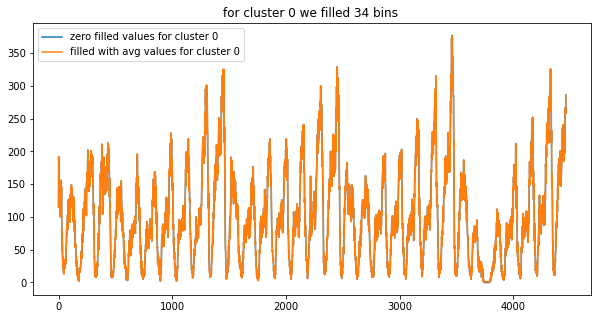

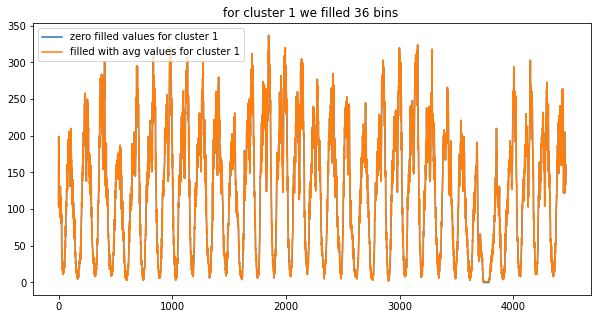

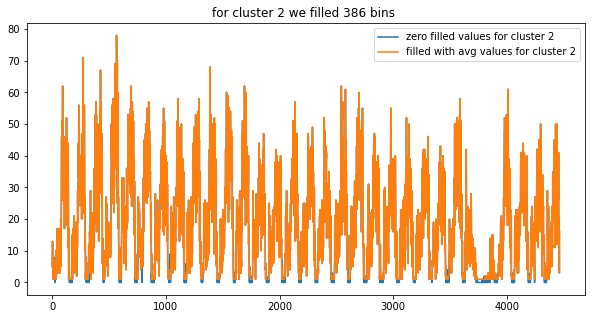

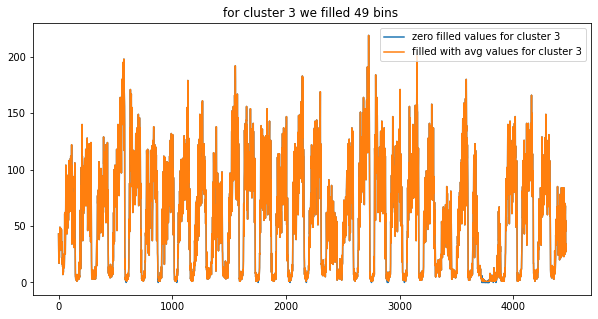

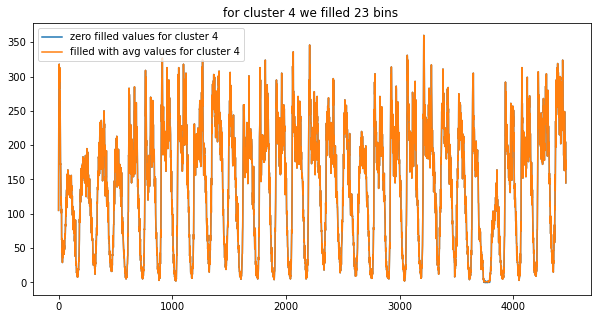

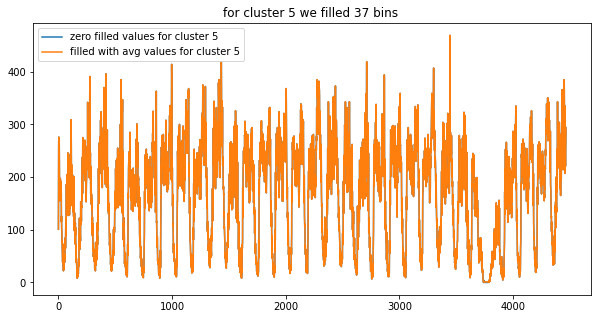

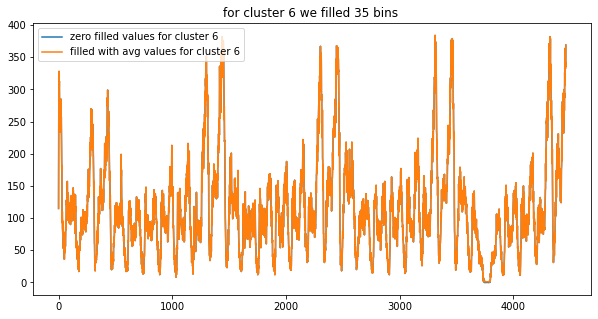

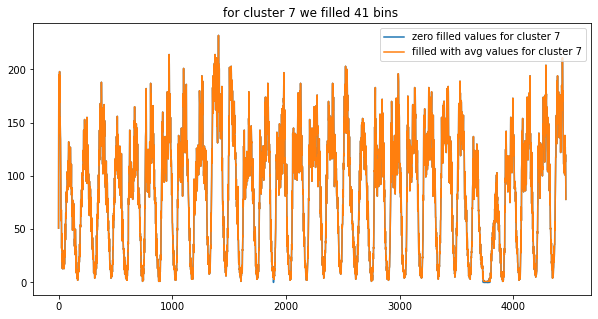

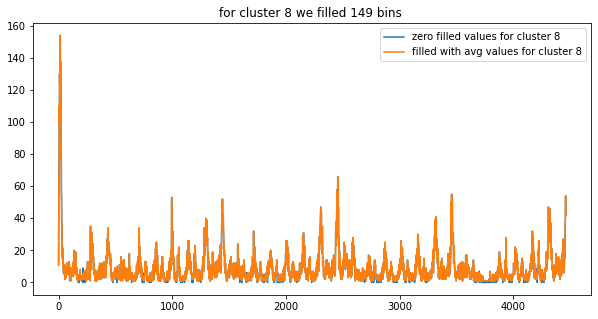

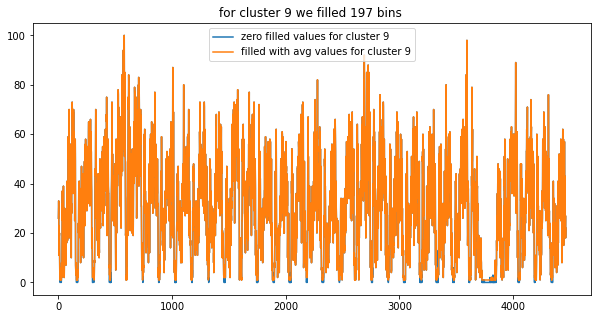

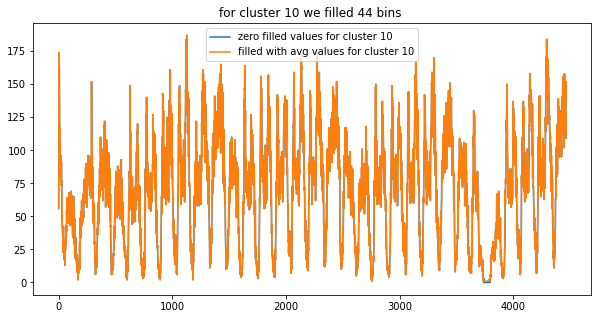

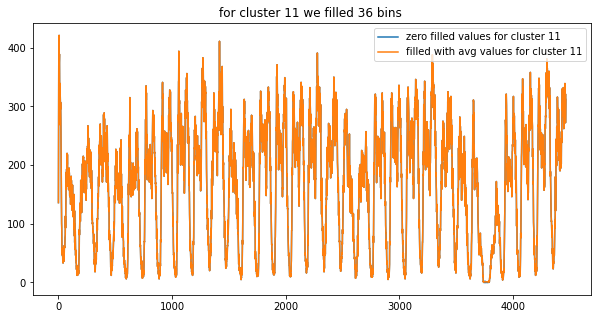

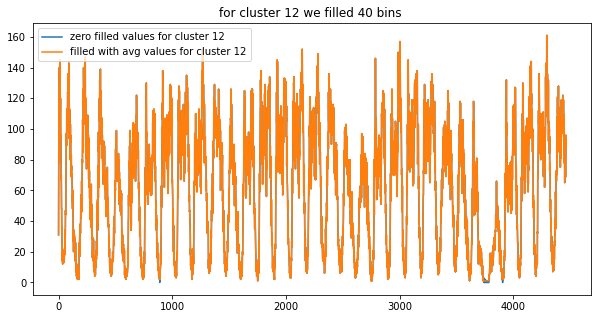

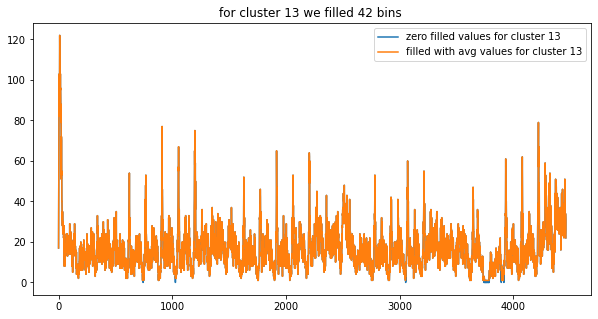

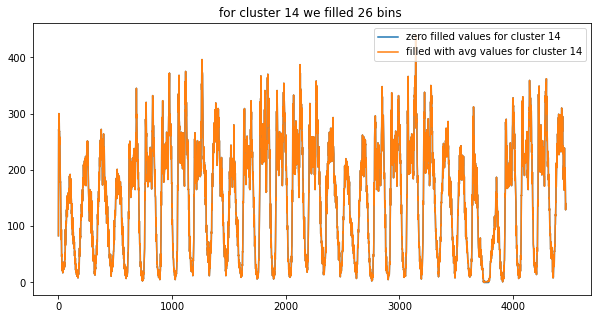

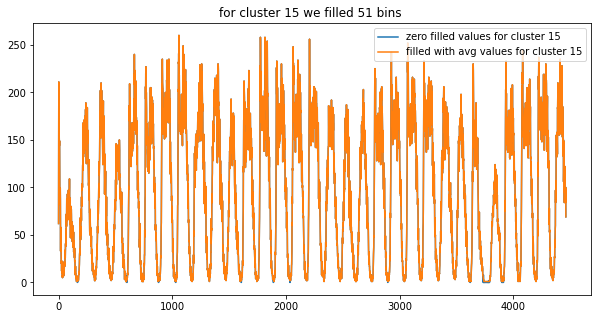

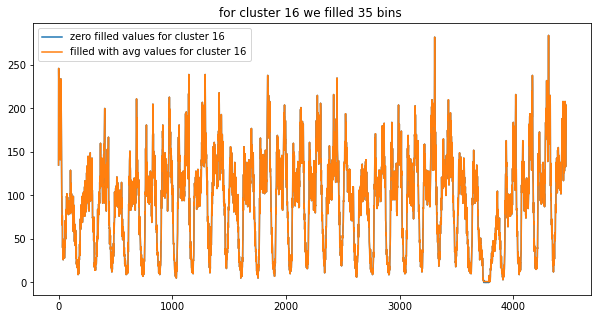

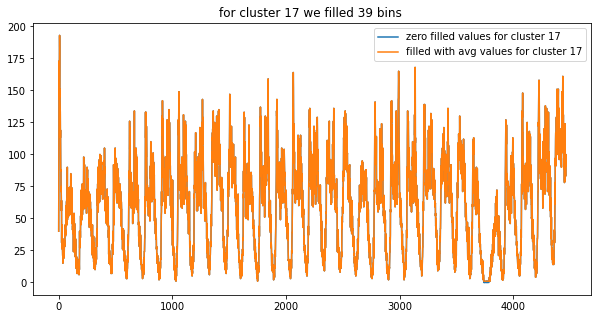

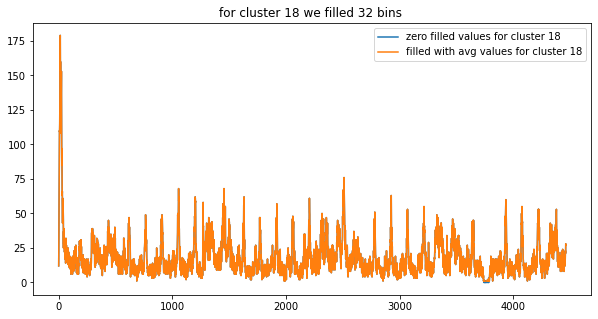

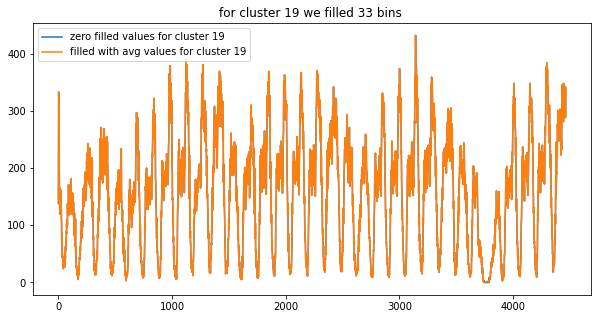

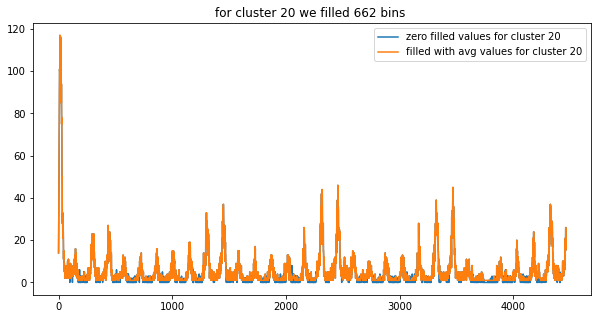

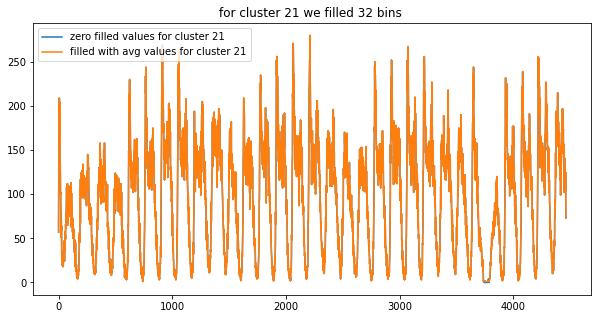

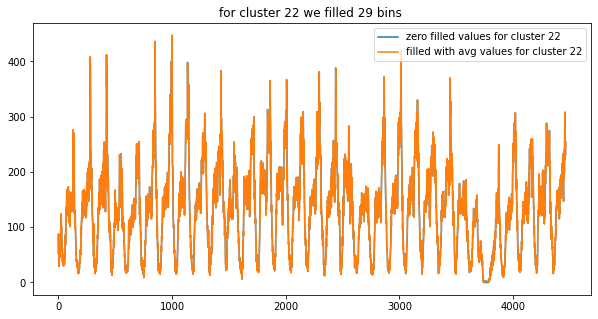

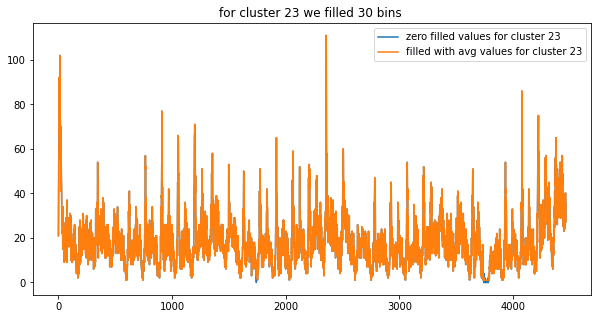

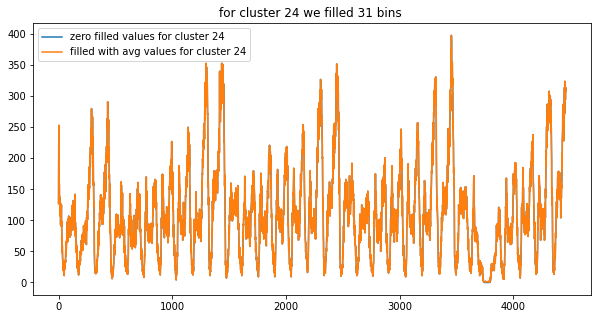

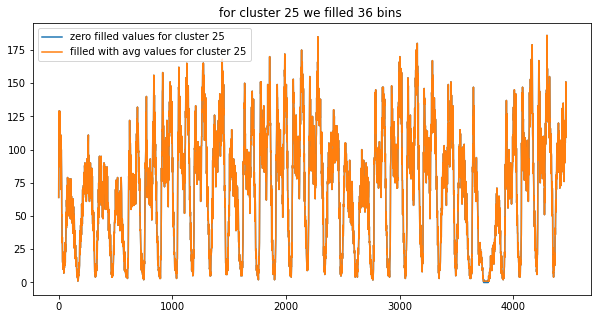

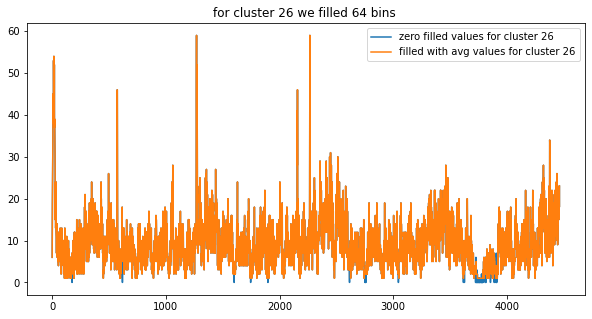

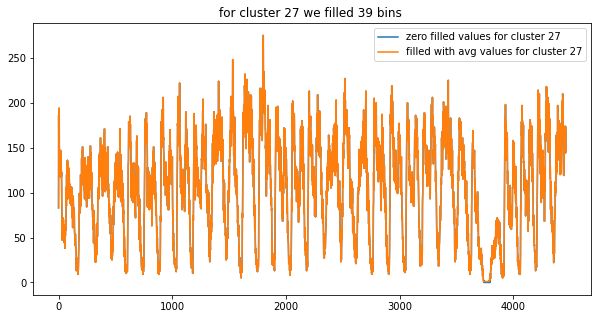

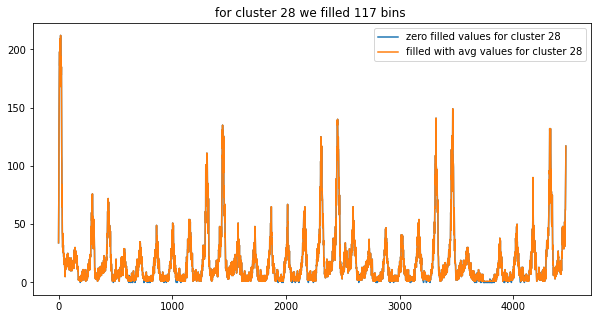

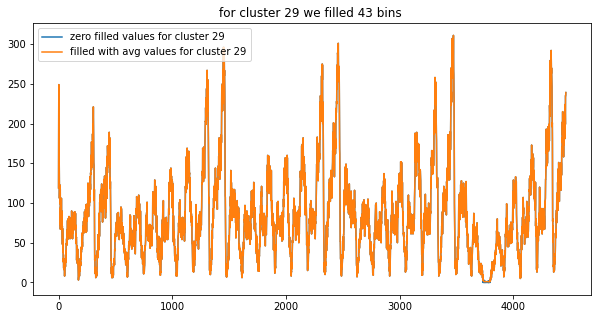

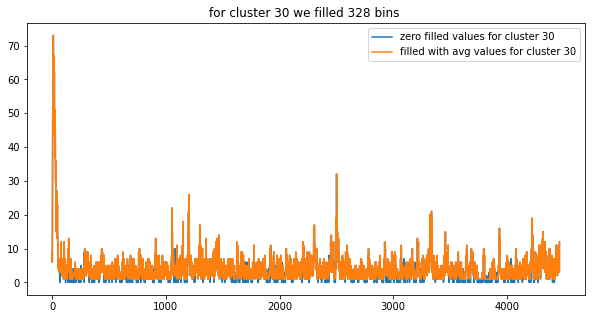

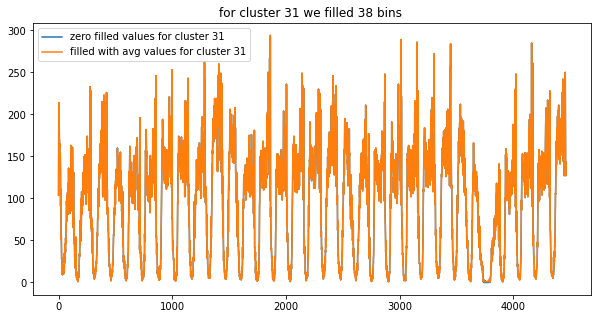

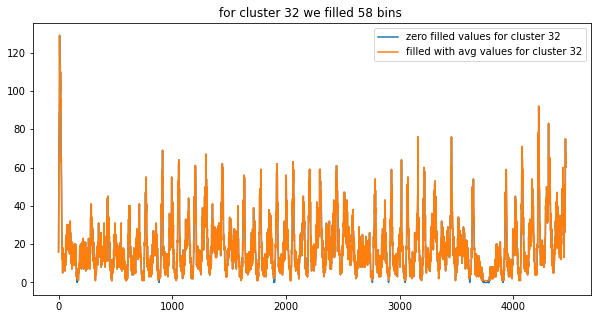

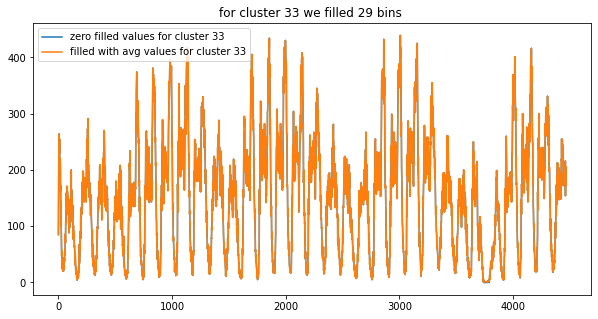

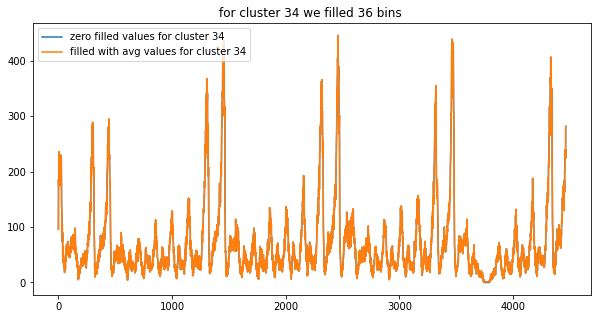

In [23]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
%matplotlib inline
j=0
for i in range(0,len(jan_2015_unique)):
    plt.figure(figsize=(10,5))
    plt.plot(jan_2015_fill_with_zero[i*4464:j+4464], label="zero filled values for cluster {}".format(i))
    plt.plot(jan_2015_smooth[i*4464:j+4464], label="filled with avg values for cluster {}".format(i))
    plt.legend()
    plt.title("for cluster {} we filled {} bins ".format(i,4464 - len(set(jan_2015_unique[i]))))
    plt.show()
    j+=4464
    


In [24]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 100 _ _ _ 150, i.e there are 100 pickups that are happened in 1st 
# st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 150 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 100, 0, 0, 140
# where as in smoothing method we replace these values as 60,60,60,60 if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.



### Remark:
    we use smoothing only for training data to avoid data leakage.
    and we use simple fill_misssing method for 2016th data (Which will be used for testing)

In [25]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
jan_2015_smooth = smoothing(jan_2015_group_frame['trip_distance'].compute().values,jan_2015_unique,4464)
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
jan_2016_smooth = fill_missing(jan_2016_group_frame['trip_distance'].compute().values,jan_2016_unique, 4464)
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
feb_2016_smooth = fill_missing(feb_2016_group_frame['trip_distance'].compute().values,feb_2016_unique,4176)
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
mar_2016_smooth = fill_missing(mar_2016_group_frame['trip_distance'].compute().values,mar_2016_unique,4464)

In [26]:
# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data


for i in range(0,35):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))

print(len(regions_cum[0]))


35
13104
